In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopandas
from datetime import date
from matplotlib.colors import ListedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable
from progressbar import ProgressBar

from statsmodels.tsa.seasonal import STL
from sklearn.cluster import KMeans

%run ../global_variables.py ./
%run ../global_functions.py ./

This notebook uses a Kmeans algorithm to cluster basins depending on the shape of their mean seasonal pattern. The number of clusters is given as an input by the user (usually 3,4 or 5).

## Colors definition

We load the climate colormap from the Koppen-Geiger classification. The variable is the opacity (0.8 by default). We also load a dictionary `climate_color_dict` that associates the color to each climate label. Color maps are either defined for all 31 zones (`approximate=False`) or for 5 largest zones (`approximate=True`).

In [2]:
approximate=True
if approximate:
    cmap_climate=ListedColormap(np.loadtxt("../datasets/other/koppen_geiger_color_array_approx.csv"))
else:
    cmap_climate=ListedColormap(np.loadtxt("../datasets/other/koppen_geiger_color_array.csv"))

# 1. Season-Trend decomposition using LOESS

## 1.1 In a given basin

In [3]:
%matplotlib notebook

In [4]:
time_idx=pd.date_range(start='01-2003',end='1-2017',freq='SM')[::2]
basins=load_basins_data(approximate)

Load water storage data from GRACE

In [5]:
hydro_var_name='TWS'
data="GRACE_JPL"

(spatial_grid,hydro_grid,time_hydro)=load_hydro_data(hydro_var_name,data,
                            time_idx,fill_value=dict_fill_value[data],version=version_data[data])

Select the basin

<IPython.core.display.Javascript object>


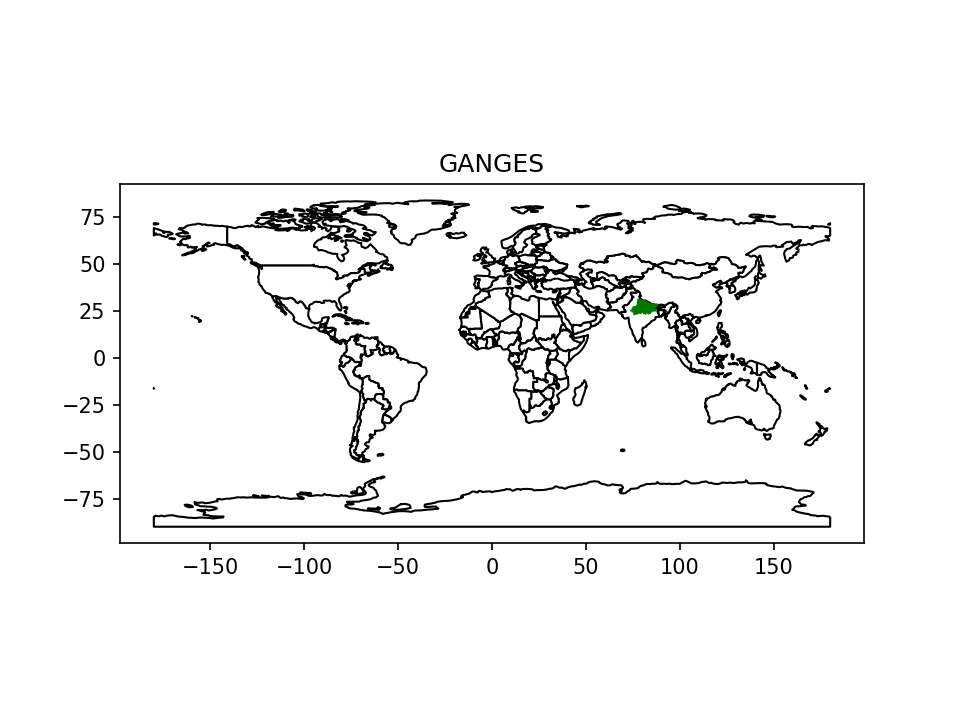

In [6]:
basin_name='GANGES'

world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
fig, ax = plt.subplots()
ax.set_aspect('equal')
world.plot(ax=ax, color='white', edgecolor='black')
basins.loc[[basin_name],'geometry'].plot(ax=ax, color=basins.loc[basin_name,'COLOR'])
plt.title(basin_name)
plt.show()

In [7]:
my_basin=basins.loc[[basin_name],'geometry']
final_selection=find_coordinates_inside_basin(my_basin,spatial_grid,basins)

Select water storage in the basin, fill missing values and compute the mean over the basin. /!\ This is not the water storage change, just the absolute water storage

In [9]:
hydro_basin=hydro_grid.loc[final_selection.index]
hydro_basin,filling=my_fillna(hydro_basin,hydro_var_name,time_idx,time_idx,data,version=version_data[data])
hydro_mean_basin=hydrological_variables_basin_filtered(hydro_basin,hydro_var_name,
                                                                time_idx,data,version=version_data[data])[0]

Perform the seasonal decomposition using LOESS decomposition

<IPython.core.display.Javascript object>


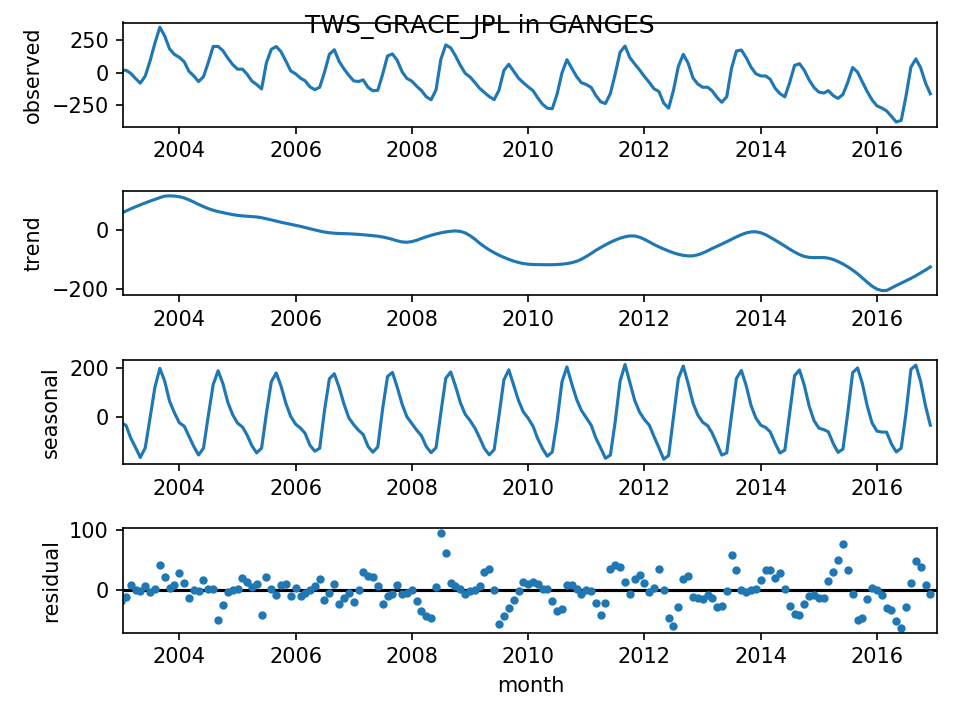

In [10]:
# change dates frequency so that LOESS determines automatically the period
df_filter=hydro_mean_basin.copy()
df_filter.index=pd.date_range(start='01-2003',end='12-2016',freq='MS')

dec = STL(df_filter).fit()

plt.figure()
plt.subplot(4,1,1)
plt.plot(dec.observed)
plt.ylabel("observed")
plt.xlim([date(2003,1,15),date(2017,1,15)]) 

plt.subplot(4,1,2)
plt.plot(dec.trend)
plt.ylabel("trend")
plt.xlim([date(2003,1,15),date(2017,1,15)])

plt.subplot(4,1,3)
plt.plot(dec.seasonal)
plt.ylabel("seasonal")
plt.xlim([date(2003,1,15),date(2017,1,15)])

plt.subplot(4,1,4)
plt.plot([date(2003,1,15),date(2017,1,15)],[0,0],'k')
plt.plot(dec.resid,'.')
plt.ylabel("residual")
plt.xlabel("month")
plt.xlim([date(2003,1,15),date(2017,1,15)])
plt.suptitle("{}_{} in {}".format(hydro_var_name,data,basin_name))
plt.tight_layout()
plt.show()

Compute the mean seasonal pattern by averaging the seasonal trend from the LOESS decomposition over the years. The noise is the standard deviation of the residual term and the magnitude is the half of the difference between the maximum and minimum of the mean seasonal pattern.

<IPython.core.display.Javascript object>


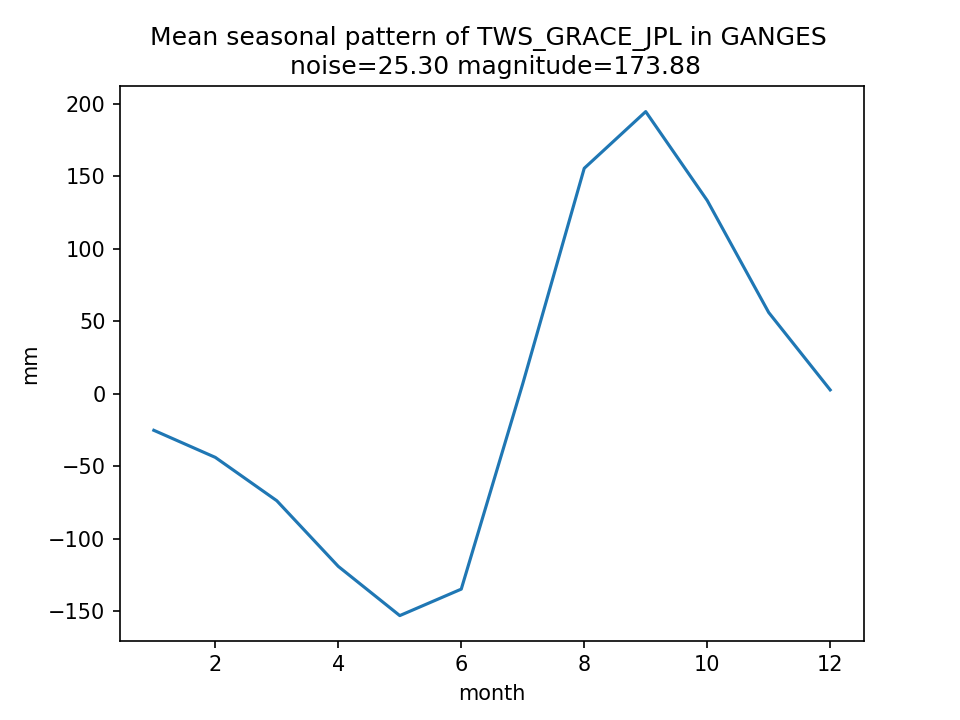

In [11]:
season=dec.seasonal.to_frame()
season['month']=season.index.month
pattern=season.groupby('month').mean()
noise=np.std(dec.resid)
magnitude=(np.max(pattern.values)-np.min(pattern.values))/2

plt.figure()
plt.plot(pattern)
plt.title("Mean seasonal pattern of {}_{} in {} \n noise={:.2f} magnitude={:.2f}".format(hydro_var_name,
                                                    data,basin_name,noise,magnitude))
plt.xlabel("month")
plt.ylabel("mm")
plt.show()

## 1.2 In a selection of basins

In [12]:
# we select basins larger than 65 000 km2 with at least 1 runoff station, or larger than 800,000 km2
selected_basins=basins.loc[((basins['RASTAREA']>=6.5e4)&(basins['NB_RUNOFF']>=1))|(basins['RASTAREA']>8e5),['COLOR','MAIN_CLIMATE','CLIMATE_AREA_%','RASTAREA','NB_RUNOFF','geometry']]

# remove Greenland and Antarctica if they have been selected
to_remove=['GREENLAND','ANTARCTICA']
for remove_basin in to_remove:
    if np.sum(selected_basins.index.isin([remove_basin]))>0:
        selected_basins.drop(remove_basin,inplace=True)

Nbasins=selected_basins.shape[0]
print("You selected {} basins, among which \n {} belong to equatorial zone \n {} to arid zone \n {} to warm temperate zone \n {} to snow zone \n {} to polar zone".format(Nbasins,
    selected_basins.loc[selected_basins['MAIN_CLIMATE']=='A'].shape[0],
    selected_basins.loc[selected_basins['MAIN_CLIMATE']=='B'].shape[0],
    selected_basins.loc[selected_basins['MAIN_CLIMATE']=='C'].shape[0],
    selected_basins.loc[selected_basins['MAIN_CLIMATE']=='D'].shape[0],
    selected_basins.loc[selected_basins['MAIN_CLIMATE']=='E'].shape[0]))

You selected 108 basins, among which 
 11 belong to equatorial zone 
 30 to arid zone 
 24 to warm temperate zone 
 43 to snow zone 
 0 to polar zone


Prepare dataframe to store results : 
- mean seasonal pattern
- magnitude
- noise

In [13]:
seasonal_patterns=pd.DataFrame(np.zeros((14,1)),index=list(np.arange(1,13))+['sigma','magnitude'],
                               columns=[selected_basins.index[0]])

Loop over basins

In [14]:
pbar=ProgressBar()

for basin_name in pbar(selected_basins.index):
    my_basin=basins.loc[[basin_name],'geometry']
    final_selection=find_coordinates_inside_basin(my_basin,spatial_grid,basins)
    
    hydro_basin=hydro_grid.loc[final_selection.index]
    hydro_basin,filling=my_fillna(hydro_basin,hydro_var_name,time_idx,time_idx,data,version=version_data[data])
    hydro_mean_basin=hydrological_variables_basin_filtered(hydro_basin,hydro_var_name,
                                                                    time_idx,data,version=version_data[data])[0]
    
    # change dates frequency so that LOESS determines automatically the period
    df_filter=hydro_mean_basin.copy()
    df_filter.index=pd.date_range(start='01-2003',end='12-2016',freq='MS')

    dec = STL(df_filter).fit()
    
    season=dec.seasonal.to_frame()
    season['month']=season.index.month
    pattern=season.groupby('month').mean()
    noise=np.std(dec.resid)
    magnitude=(np.max(pattern.values)-np.min(pattern.values))/2
    
    seasonal_patterns.loc[np.arange(1,13),basin_name]=pattern.values.flatten()
    seasonal_patterns.loc['sigma',basin_name]=noise
    seasonal_patterns.loc['magnitude',basin_name]=magnitude

100% |########################################################################|


# 2. Cluster basins depending on their mean seasonal pattern

## 2.1. Create clusters

Kmeans algorithm to create cluster of basins depending on the shape of their mean seasonal water storage. Seasonal patterns are normalized to cluster independently from the magnitude. 

In [37]:
pattern_norm=normalize(seasonal_patterns.iloc[:12,:],a=-1,b=1)

# number of cluster we assume
Nclusters=5

# run the Kmeans algorithm
kmeans = KMeans(n_clusters=Nclusters, random_state=0).fit(pattern_norm.values.T)

Compute the number of basins per cluster from printing

In [38]:
basins_k=[] # list of k lists, each one containing the basin names in the corresponding cluster
nb_basins_per_k=[] # number of basins per cluster
for k in range(Nclusters):
    X=np.where(kmeans.labels_==k)[0]
    basins_k.append(selected_basins.index[X])
    nb_basins_per_k.append(X.shape[0])

Add the cluster number to each basin

In [40]:
for k in range(Nclusters):
    seasonal_patterns.loc['cluster',basins_k[k]]=k

Plot the mean seasonal pattern of all basins. Each column represents a different cluster.

<IPython.core.display.Javascript object>


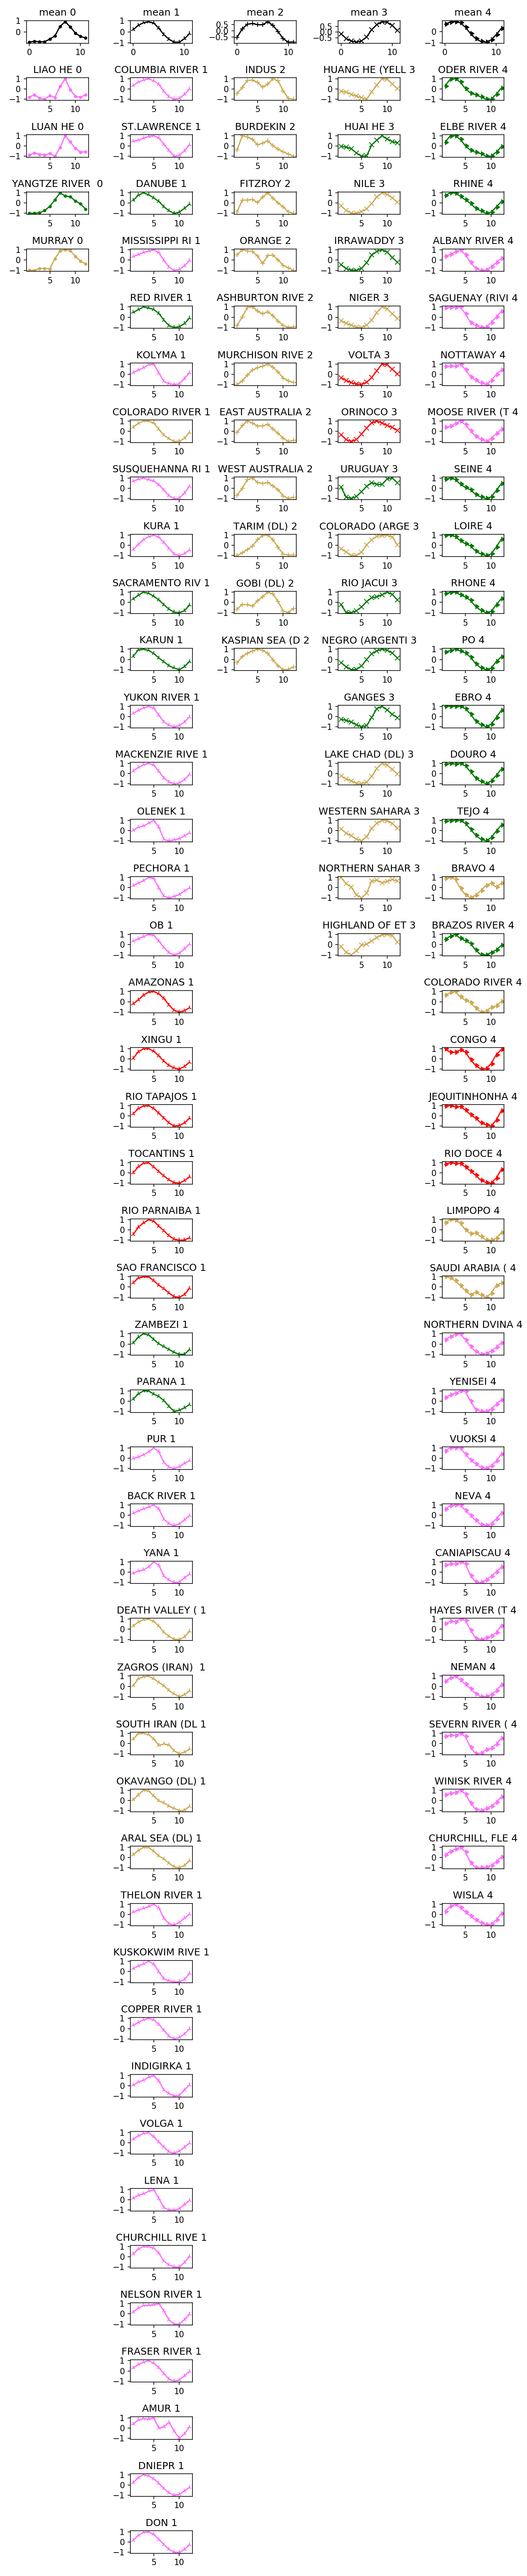

In [41]:
N=seasonal_patterns.shape[1]
max_nb_basins_per_k=np.max(nb_basins_per_k)
markerstyles = ['.','2','+','x',9,10]
plt.figure(figsize=(9,max_nb_basins_per_k))
for k in range(Nclusters):
    plt.subplot(max_nb_basins_per_k+1,Nclusters,k+1)
    plt.plot(kmeans.cluster_centers_[k,:],'k',marker=markerstyles[k])
    plt.title('mean {}'.format(k))
    
    for i,basin_name in enumerate(basins_k[k]):
        plt.subplot(max_nb_basins_per_k+1,Nclusters,Nclusters*(i+1)+k+1)
        plt.plot(pattern_norm.loc[:,basin_name],color=basins.loc[basin_name,'COLOR'],
                marker=markerstyles[k])
        plt.title('{} {}'.format(basin_name[:14],k))
plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


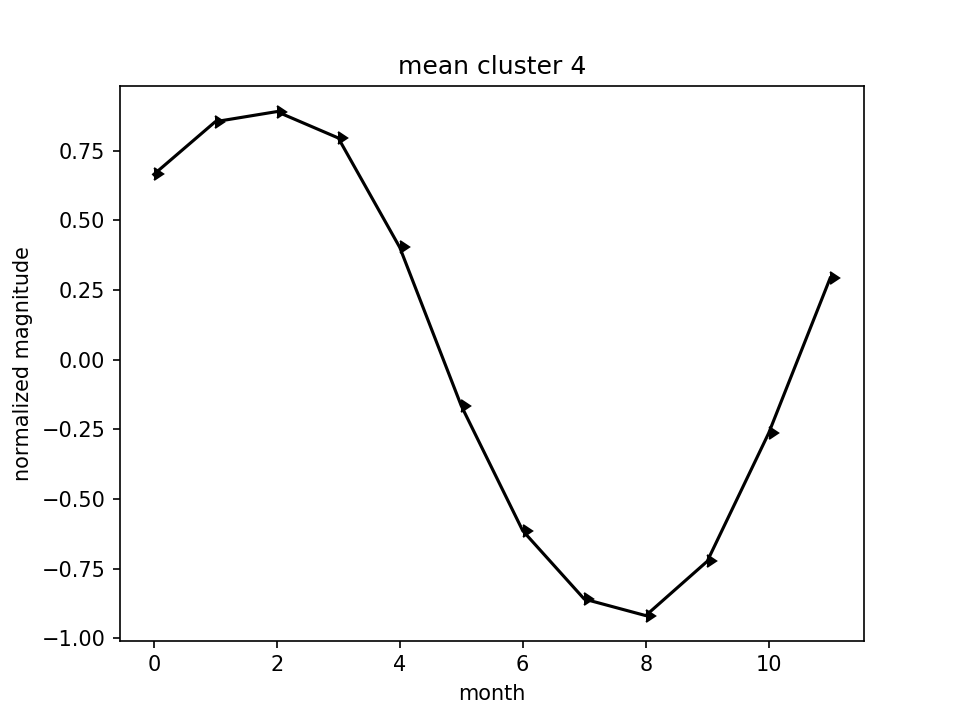

In [42]:
k=4
plt.figure()
plt.plot(kmeans.cluster_centers_[k,:],'k',marker=markerstyles[k])
plt.title('mean cluster {}'.format(k))
plt.xlabel('month')
plt.ylabel('normalized magnitude')
plt.show()

## 2.2 Plot NSE results depending on cluster

In [43]:
def find_separation_datasets(datasets):
    # name of datasets
    data_P=[]
    data_ET=[]
    data_R=[]
    for data_name in datasets:
        iP=data_name.find('_ET')
        data_P.append(data_name[:iP])
        iET=data_name.find('_R',iP+1)
        data_ET.append(data_name[iP+1:iET])
        iR=data_name.find('_TWS',iET+1)
        data_R.append(data_name[iET+1:iR])
    
    sep_P=np.unique(data_P,return_index=True)[1]
    sep_P_unsorted=sep_P.copy()
    sep_P.sort()
    sep_ET=[]
    for i in range(len(sep_P)-1):
        sep_ET+=list(sep_P[i]+np.unique(data_ET[sep_P[i]:sep_P[i+1]],return_index=True)[1])
    sep_ET+=list(sep_P[-1]+np.unique(data_ET[sep_P[-1]:],return_index=True)[1])

    return data_P,data_ET,data_R,sep_P_unsorted,sep_ET

In [44]:
def plot_performance_matrix(perf,perf_tab,xlim=-3.5,discrete=True,save_fig=False,width=24,height=8,group='climate'):
    if group=='climate':
        perf_tab=perf_tab.sort_values(by=['MAIN_CLIMATE','RASTAREA'])
    if group=='cluster':
        perf_tab=perf_tab.sort_values(by=['CLUSTER','SIGNAL2NOISE'])
    
    datasets=perf_tab.columns[np.where(perf_tab.columns.str[:2]=='P_')]
    data_P,data_ET,data_R,sep_P,sep_ET=find_separation_datasets(datasets)
    
    max_tab=pd.DataFrame(np.max(perf_tab[datasets],axis=1),index=perf_tab.index,columns=['max_perf'])
    for basin_name in max_tab.index:
        temp=np.array(perf_tab.loc[basin_name,datasets],dtype='float')
        temp[np.isnan(temp)]=-100
        max_tab.loc[basin_name,'best_dataset']=datasets[np.argmax(temp)]
    
    if group=='climate':
        nbA=perf_tab.loc[perf_tab['MAIN_CLIMATE']=='A'].shape[0]
        nbAB=nbA+perf_tab.loc[perf_tab['MAIN_CLIMATE']=='B'].shape[0]
        nbAC=nbAB+perf_tab.loc[perf_tab['MAIN_CLIMATE']=='C'].shape[0]
        nbAD=nbAC+perf_tab.loc[perf_tab['MAIN_CLIMATE']=='D'].shape[0]
        nbAE=nbAD+perf_tab.loc[perf_tab['MAIN_CLIMATE']=='E'].shape[0]
        
        colorA=climate_color_dict['A']
        colorB=climate_color_dict['B']
        colorC=climate_color_dict['C']
        colorD=climate_color_dict['D']
        colorE=climate_color_dict['E']
        
    if group=='cluster':
        nbA=perf_tab.loc[perf_tab['CLUSTER']==0].shape[0]
        nbAB=nbA+perf_tab.loc[perf_tab['CLUSTER']==1].shape[0]
        nbAC=nbAB+perf_tab.loc[perf_tab['CLUSTER']==2].shape[0]
        nbAD=nbAC+perf_tab.loc[perf_tab['CLUSTER']==3].shape[0]
        nbAE=nbAD+perf_tab.loc[perf_tab['CLUSTER']==4].shape[0]
        
        colorA='brown'
        colorB='pink'
        colorC='grey'
        colorD='olive'
        colorE='cyan'
    
    norm,cmap=define_cmap_perf(perf,discrete=discrete)

    fig, ax = plt.subplots(figsize=(width,2.28+0.17*perf_tab.shape[0]))
    im=ax.imshow(perf_tab[datasets],cmap=cmap,norm=norm,aspect='auto')
    if perf=='NSE': # from - inf to 1
        plt.colorbar(im, ax=ax,label=perf,fraction=0.02,extend='min')
    elif perf=='PBIAS': # from - inf to + inf
        plt.colorbar(im, ax=ax,label=perf,fraction=0.02,extend='both')
    else: # from -1 to 1
        plt.colorbar(im, ax=ax,label='correlation',fraction=0.5)
        
    # best dataset
    for ibasin,basin_name in enumerate(max_tab.index):
        j=np.where(max_tab.loc[basin_name,'best_dataset']==datasets)[0][0]
        d=0.5
        plt.plot([j-d,j-d],[ibasin-d,ibasin+d],'k')
        plt.plot([j+d,j+d],[ibasin-d,ibasin+d],'k')
        plt.plot([j-d,j+d],[ibasin-d,ibasin-d],'k')
        plt.plot([j-d,j+d],[ibasin+d,ibasin+d],'k')
        #plt.plot(j,ibasin,'ko')
    
    if nbA>0:
        plt.plot([xlim,len(datasets)-0.5],[nbA-0.5,nbA-0.5],color=colorA)
        plt.plot([-0.55,-0.55],[-0.5,nbA-0.5],color=colorA)
    
    if nbAB>nbA:
        plt.plot([xlim,len(datasets)-0.5],[nbAB-0.5,nbAB-0.5],color=colorB)
        plt.plot([-0.55,-0.55],[nbA-0.5,nbAB-0.5],color=colorB)
    
    if nbAC>nbAB:
        plt.plot([xlim,len(datasets)-0.5],[nbAC-0.5,nbAC-0.5],color=colorC)
        plt.plot([-0.55,-0.55],[nbAB-0.5,nbAC-0.5],color=colorC)
    
    if nbAD>nbAC:
        plt.plot([xlim,len(datasets)-0.5],[nbAD-0.5,nbAD-0.5],color=colorD)
        plt.plot([-0.55,-0.55],[nbAC-0.5,nbAD-0.5],color=colorD)
        
    if nbAE>nbAD:
        plt.plot([-0.55,-0.55],[nbAD-0.5,Nbasins-0.5],color=colorE)
       
    for sep_ETx in sep_ET:
        if sep_ETx!=0:
            plt.plot([-0.5+sep_ETx]*2,[-0.5,Nbasins-0.5],':',color='teal')
        
    for sep_Px in sep_P:
        if sep_Px!=0:
            plt.plot([-0.5+sep_Px]*2,[-0.5,Nbasins-0.5],color='dodgerblue')

    if group=='climate':
        xlim=-1.5
        # number of runoff stations
        for i,nb_runoff in enumerate(perf_tab['NB_RUNOFF']):
            plt.text(xlim+0.1,i+0.3,nb_runoff,fontsize=8)
    
    if group=='cluster':
        # climate area
        for i,clim_area in enumerate(perf_tab['MAIN_CLIMATE']):
            plt.text(xlim+0.8,i+0.3,clim_area,fontsize=8)

        # magnitude
        for i,magn in enumerate(perf_tab['SEASON_MAGNITUDE']):
            plt.text(xlim+1.3,i+0.3,np.round(magn,1),fontsize=8)

        # signal to noise ratio
        for i,noise in enumerate(perf_tab['SIGNAL2NOISE']):
            plt.text(xlim+2.3,i+0.3,np.round(noise,1),fontsize=8)
    
    # draw column separation between datasets
    for sep_Px in sep_P:
        plt.text(sep_Px+2,perf_tab.shape[0]+8,data_P[sep_Px],{'color':'dodgerblue'})
    plt.text(sep_Px+2,perf_tab.shape[0]+9,'blank',{'color':'white'})
    
    for sep_ETx in sep_ET:
        plt.text(sep_ETx,perf_tab.shape[0]+7,data_ET[sep_ETx],{'color':'teal'})
        
    if perf=='corr_basins':
        perf='correlation'

    ax.set_yticks(np.arange(perf_tab.shape[0]))
    ax.set_yticklabels(perf_tab.index)
    
    if group=='climate':
        ax.set_xticks([-1]+list(np.arange(len(datasets))))
        ax.set_xticklabels(['nb runoff stations']+list(data_R))    
    if group=='cluster':
        ax.set_xticks([-2.5,-1.8,-1]+list(np.arange(len(datasets))))
        ax.set_xticklabels(['main climate','magnitude','signal to noise']+list(data_R))
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    ax.set_xlim([xlim-0.3,len(datasets)-0.5])
    ax.set_ylim([perf_tab.shape[0]-0.5,-0.5])
    ax.set_title(perf)
    
    if perf_tab.shape[0]==4:
        fig.subplots_adjust(bottom=0.62,top=0.9) 
    elif perf_tab.shape[0]==11:
        fig.subplots_adjust(bottom=0.41,top=0.92)
    elif perf_tab.shape[0]==16:
        fig.subplots_adjust(bottom=0.35,top=0.95)
    elif perf_tab.shape[0]==33:
        fig.subplots_adjust(bottom=0.2,top=0.97)
    elif perf_tab.shape[0]==44:
        fig.subplots_adjust(bottom=0.17,top=0.97)
    else:
        fig.tight_layout()
    
    if save_fig:
        plt.savefig('../plots/water_budget/{}_{}basins_{}datasets_{}.png'.format(perf,Nbasins,len(datasets),group))
    plt.show()

In [45]:
%matplotlib notebook

Nbasins=108
Ndatasets=50
NSE_tab=pd.read_csv("../results/water_budget/NSE_tab_{}basins_{}datasets.csv".format(Nbasins,Ndatasets),index_col=[0])

NSE_tab['NB_RUNOFF']=NSE_tab['NB_RUNOFF'].astype(int)
NSE_tab['NB_RUNOFF_PER_KM2']=np.round(1e6*NSE_tab['NB_RUNOFF'].values/NSE_tab['RASTAREA'],1)
NSE_tab.loc[:,'CLUSTER']=seasonal_patterns.loc['cluster']
NSE_tab.loc[:,'SEASON_MAGNITUDE']=seasonal_patterns.loc['magnitude']
NSE_tab.loc[:,'SIGNAL2NOISE']=seasonal_patterns.loc['sigma']/seasonal_patterns.loc['magnitude']

<IPython.core.display.Javascript object>


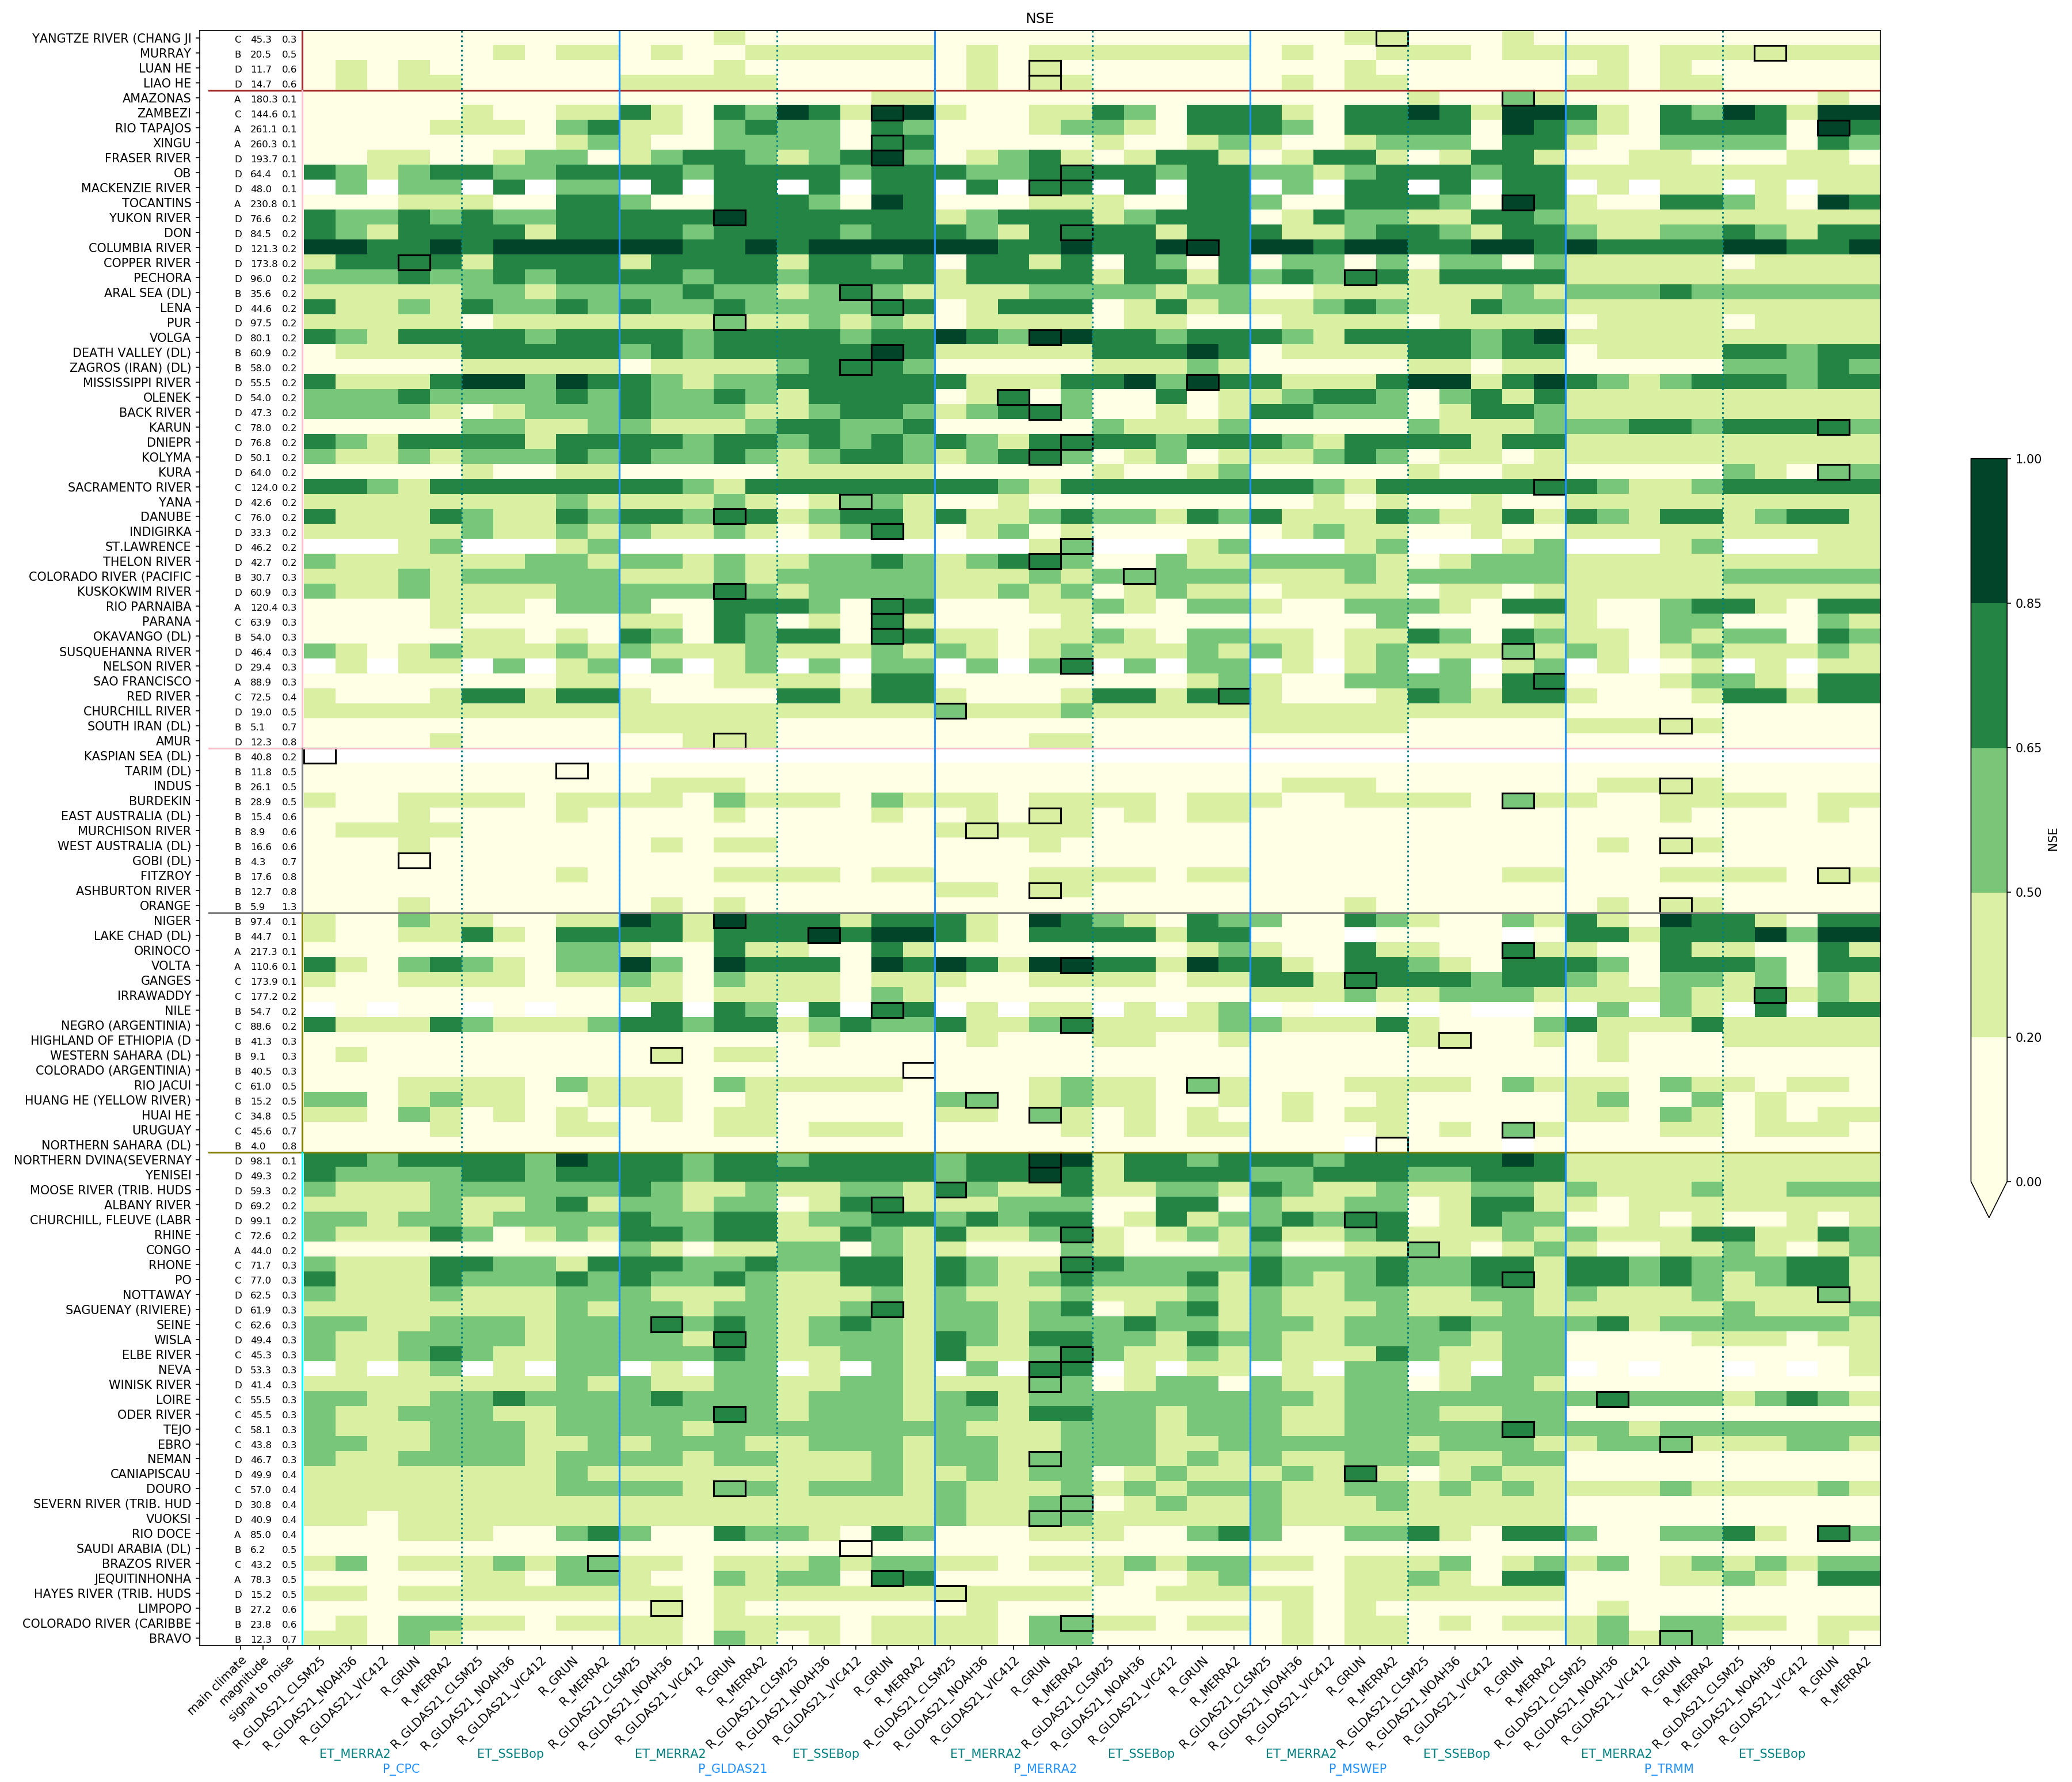

In [46]:
plot_performance_matrix('NSE',NSE_tab,width=24,group='cluster')

Plot NSE in a given cluster

<IPython.core.display.Javascript object>


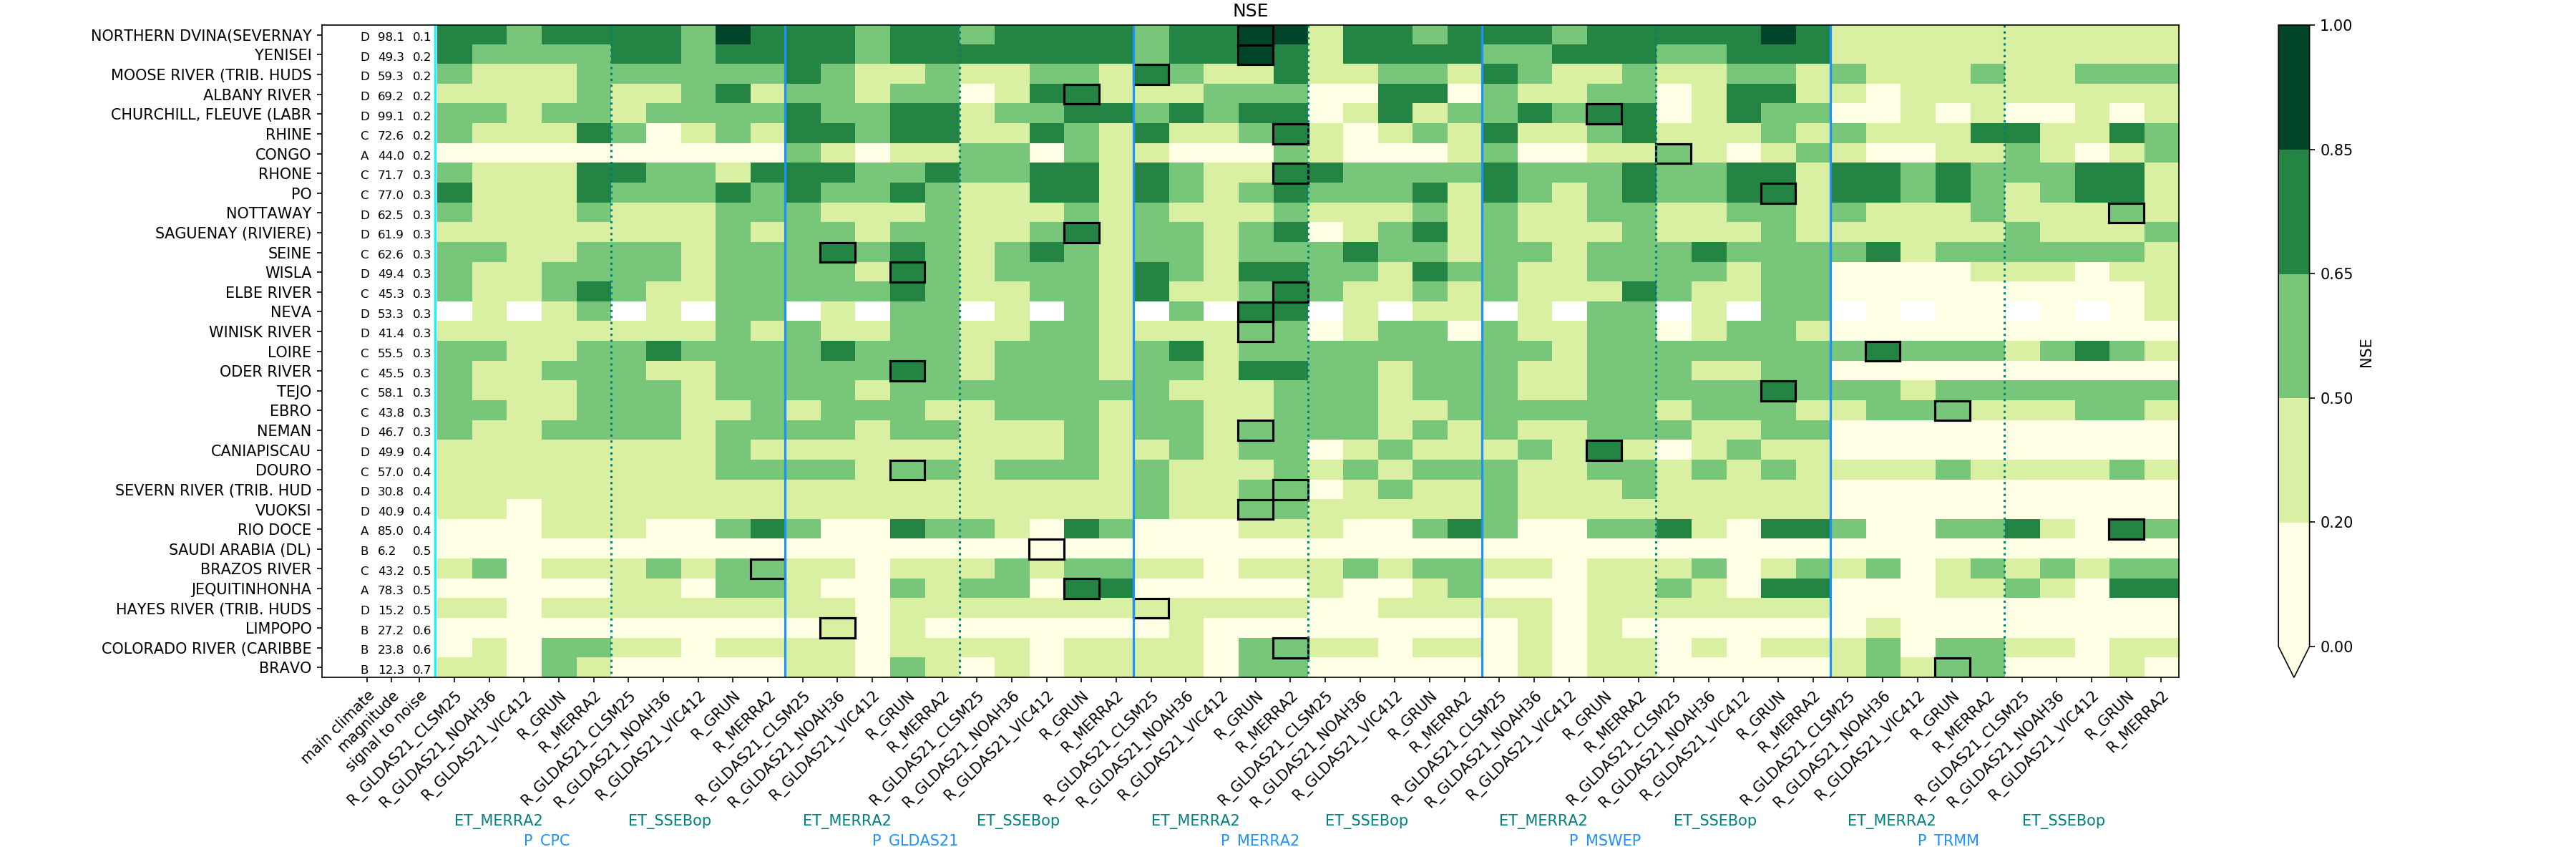

In [47]:
k=4
plot_performance_matrix('NSE',NSE_tab.loc[NSE_tab['CLUSTER']==k],width=24,group='cluster')

Overall performances per cluster

In [51]:
datasets=NSE_tab.columns[np.where(NSE_tab.columns.str[:2]=='P_')]
max_NSE_tab=pd.DataFrame(np.max(NSE_tab[datasets],axis=1),index=NSE_tab.index,columns=['max_NSE'])
for basin_name in max_NSE_tab.index:
    temp=np.array(NSE_tab.loc[basin_name,datasets],dtype='float')
    temp[np.isnan(temp)]=-100
    max_NSE_tab.loc[basin_name,'best_dataset']=datasets[np.argmax(temp)]

In [52]:
k=4
print('{} basins excellent'.format(max_NSE_tab.loc[(NSE_tab['CLUSTER']==k)&(max_NSE_tab['max_NSE']>=0.85)].shape[0]))
print('{} basins very good'.format(max_NSE_tab.loc[(NSE_tab['CLUSTER']==k)&(max_NSE_tab['max_NSE']<0.85)&(max_NSE_tab['max_NSE']>=0.65)].shape[0]))
print('{} basins good'.format(max_NSE_tab.loc[(NSE_tab['CLUSTER']==k)&(max_NSE_tab['max_NSE']<0.65)&(max_NSE_tab['max_NSE']>=0.5)].shape[0]))
print('{} basins poor'.format(max_NSE_tab.loc[(NSE_tab['CLUSTER']==k)&(max_NSE_tab['max_NSE']<0.5)&(max_NSE_tab['max_NSE']>=0.2)].shape[0]))
print('{} basins very poor'.format(max_NSE_tab.loc[(NSE_tab['CLUSTER']==k)&(max_NSE_tab['max_NSE']<0.2)].shape[0]))

2 basins excellent
17 basins very good
11 basins good
2 basins poor
1 basins very poor


Overall performances

In [53]:
print('{} basins excellent'.format(max_NSE_tab.loc[(max_NSE_tab['max_NSE']>=0.85)].shape[0]))
print('{} basins very good'.format(max_NSE_tab.loc[(max_NSE_tab['max_NSE']<0.85)&(max_NSE_tab['max_NSE']>=0.65)].shape[0]))
print('{} basins good'.format(max_NSE_tab.loc[(max_NSE_tab['max_NSE']<0.65)&(max_NSE_tab['max_NSE']>=0.5)].shape[0]))
print('{} basins poor'.format(max_NSE_tab.loc[(max_NSE_tab['max_NSE']<0.5)&(max_NSE_tab['max_NSE']>=0.2)].shape[0]))
print('{} basins very poor'.format(max_NSE_tab.loc[(max_NSE_tab['max_NSE']<0.2)].shape[0]))

14 basins excellent
47 basins very good
24 basins good
17 basins poor
5 basins very poor


Plot all basins having at least 1 dataset combination performing very good

<IPython.core.display.Javascript object>


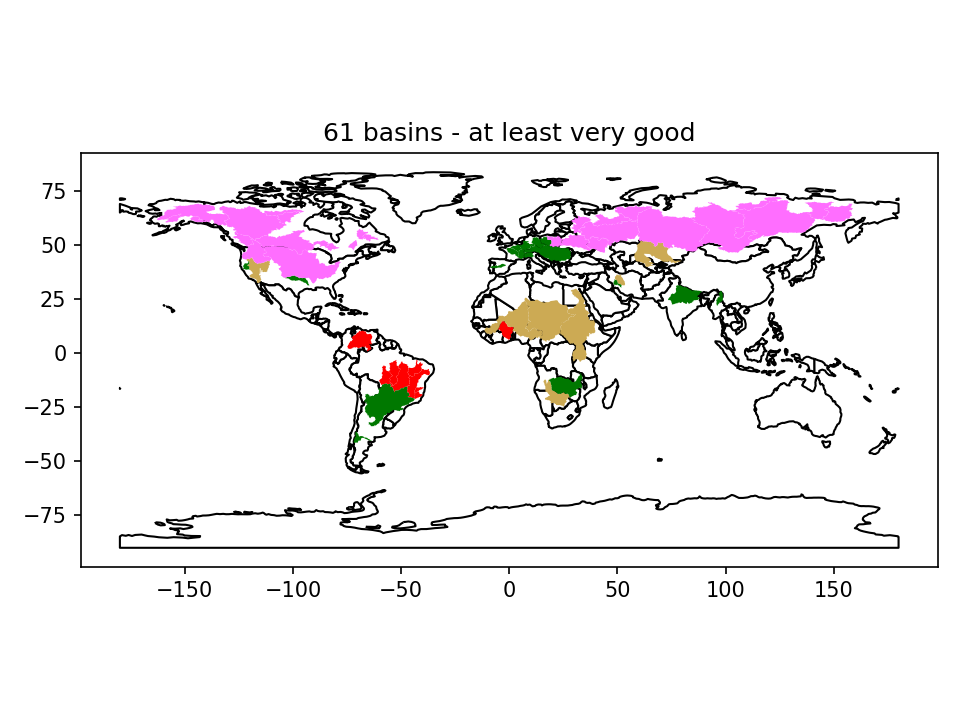

In [54]:
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
fig, ax = plt.subplots()
ax.set_aspect('equal')
world.plot(ax=ax, color='white', edgecolor='black')
n=0
for basin_name in NSE_tab.loc[(max_NSE_tab['max_NSE']>=0.65)].index:
    n+=1
    basins.loc[[basin_name],'geometry'].plot(ax=ax, color=basins.loc[basin_name,'COLOR'])
plt.title("{} basins - at least very good".format(n))
plt.tight_layout()
plt.show()